In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model

### 1.季节性数据

In [3]:
# 首先从大的趋势上看，车流量应该有一个季节性的变化，应该针对每一条路，画出3月到7月的travel_time的变化，时间粒度为hour
pre_train_path = '../data/pre_training.csv'
df = pd.read_csv(pre_train_path, delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})

In [4]:
df.head()

,link_ID,time_interval_begin,date,travel_time
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752


In [5]:
df['travel_time2'] = df['travel_time']
df['date_hour'] = df.time_interval_begin.map(lambda x: x.strftime('%Y-%m-%d-%H'))

In [6]:
df.head()

,link_ID,time_interval_begin,date,travel_time,travel_time2,date_hour
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752,2.174752,2017-03-01-06
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752,2.174752,2017-03-01-06
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752,2.174752,2017-03-01-06
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752,2.174752,2017-03-01-06
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752,2.174752,2017-03-01-06


In [7]:
# 查看季节行趋势
def date_trend(group):
    tmp = group.groupby('date_hour').mean().reset_index()
    return tmp

In [9]:
tmp = df.groupby('link_ID').apply(date_trend)

In [22]:
tmp.columns

Index(['date_hour', 'travel_time', 'travel_time2'], dtype='object')

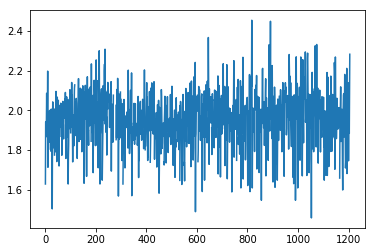

In [26]:
tmp.loc['3377906280028510514']['travel_time2'].plot()
plt.show()

In [66]:
# 显示所有道路的趋势
# groupby 根据key拆分pandas对象，然后计算分组函数，最后进行合并,apply相当于对每个对象都进行一遍操作
def plot_date_trend(group):
    tmp = group.groupby('date_hour').mean().reset_index()
    plt.plot(tmp.index,tmp['travel_time'],'ro')
    plt.title(group.link_ID.values[0])
    plt.show()

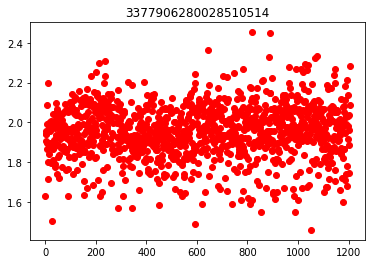

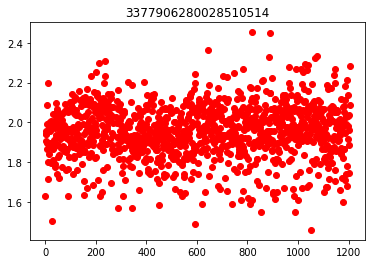

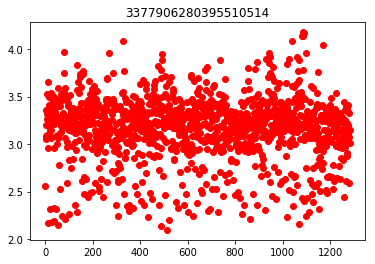

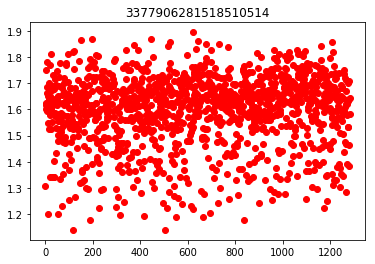

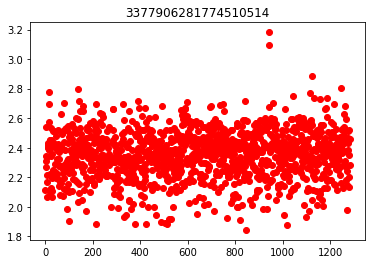

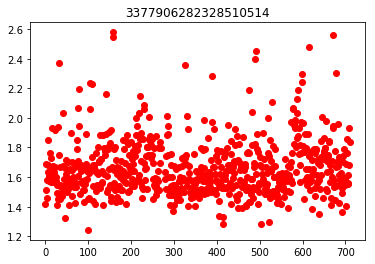

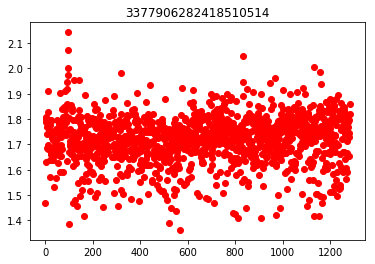

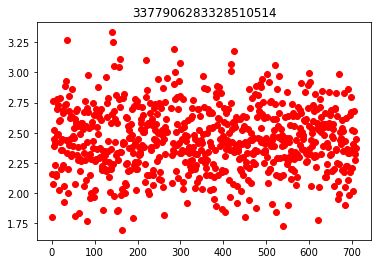

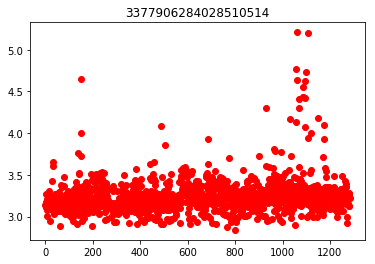

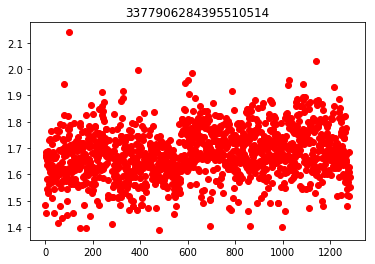

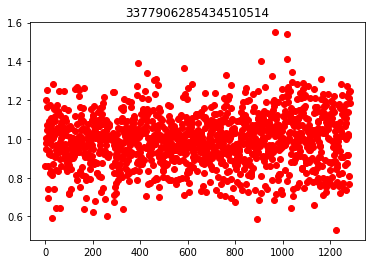

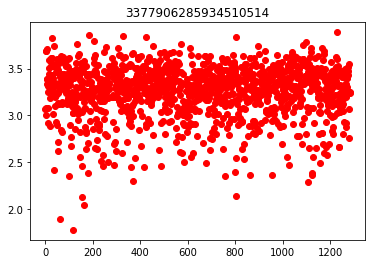

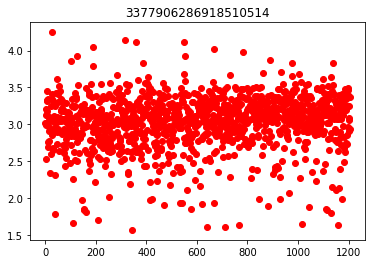

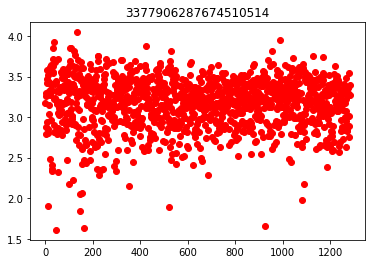

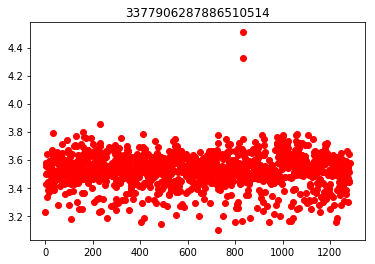

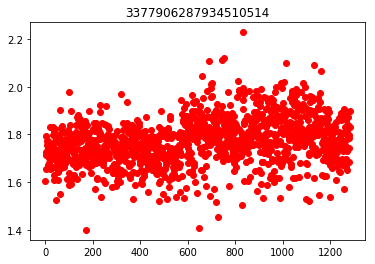

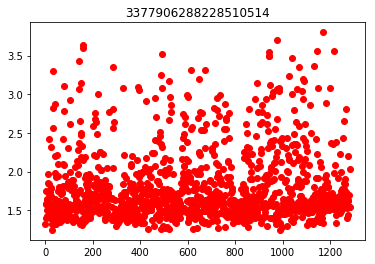

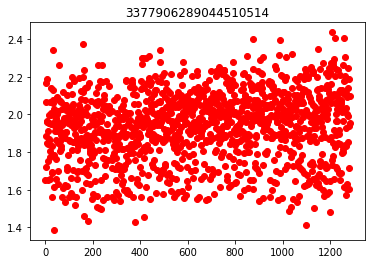

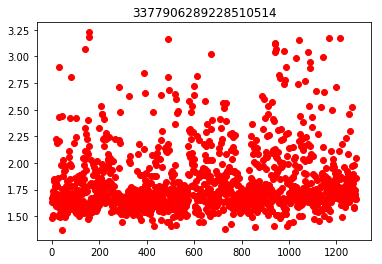

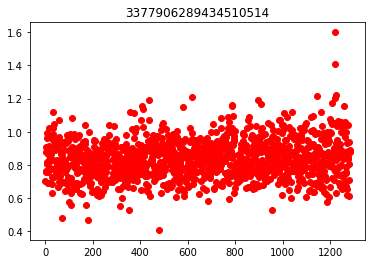

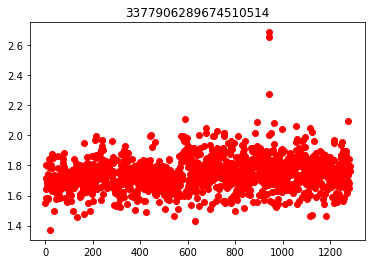

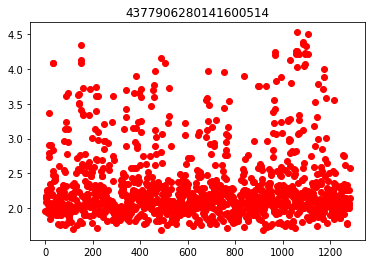

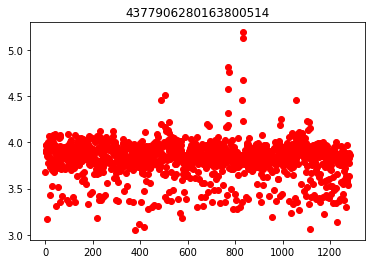

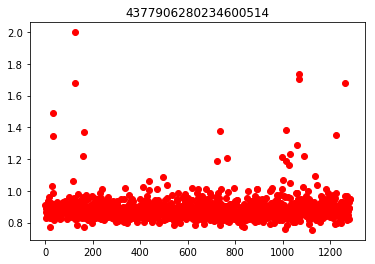

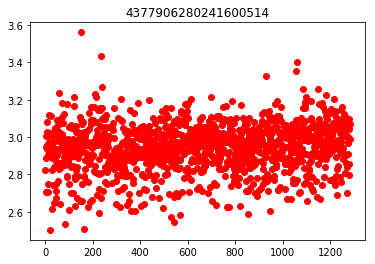

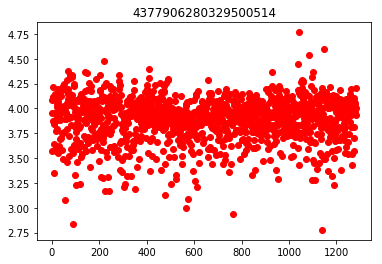

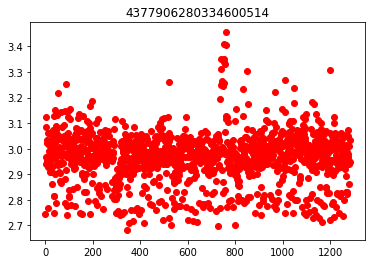

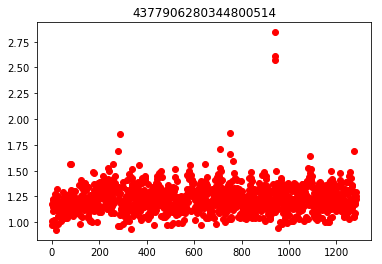

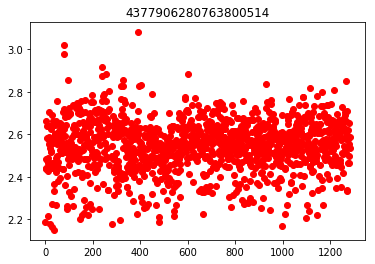

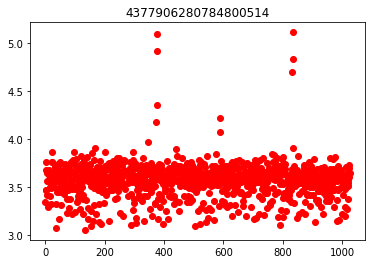

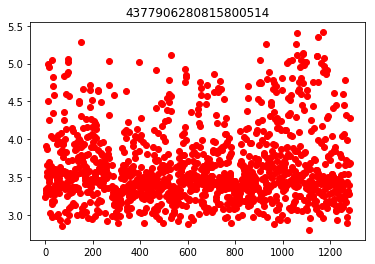

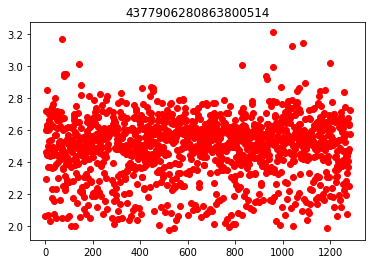

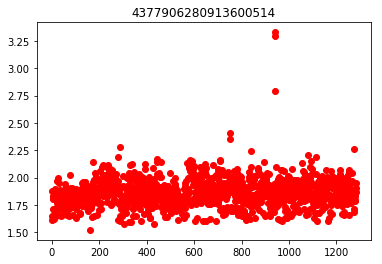

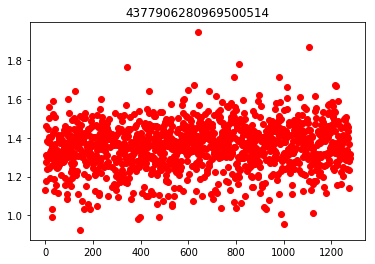

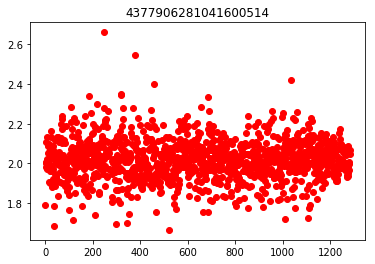

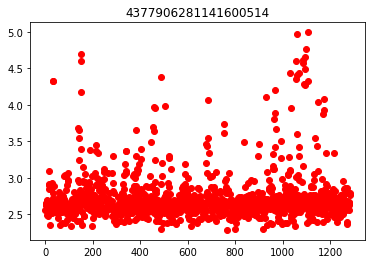

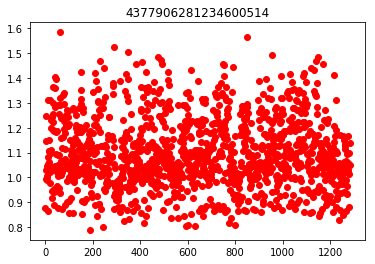

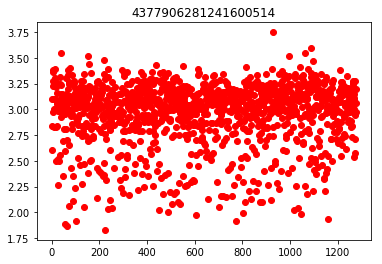

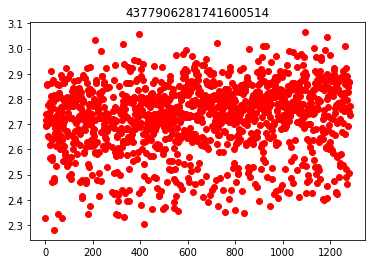

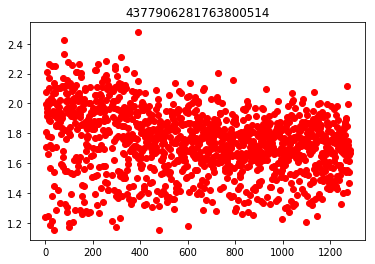

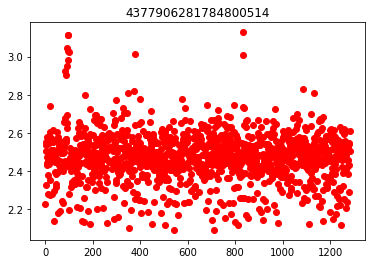

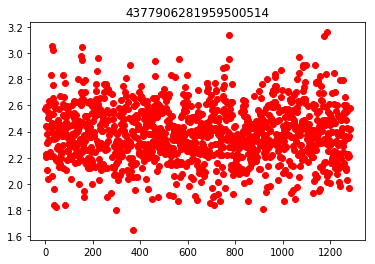

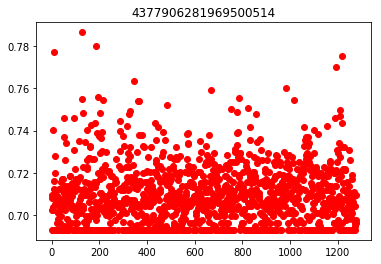

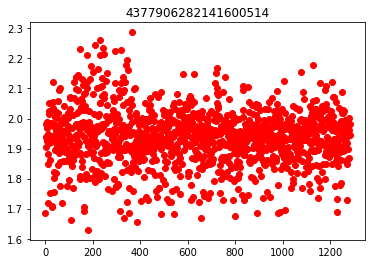

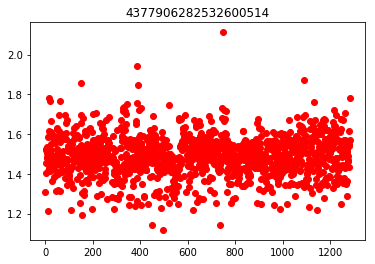

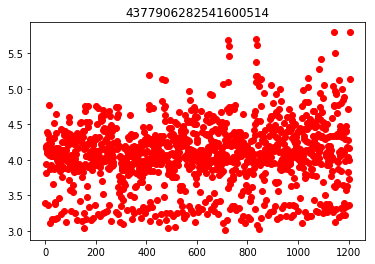

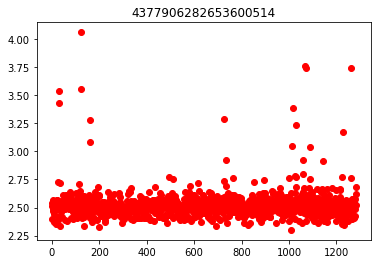

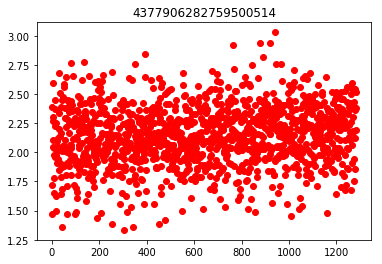

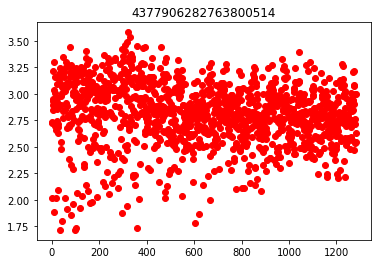

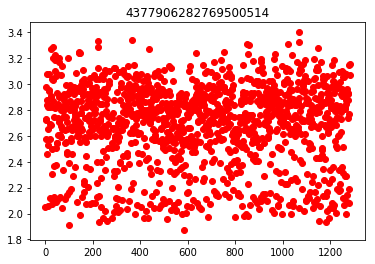

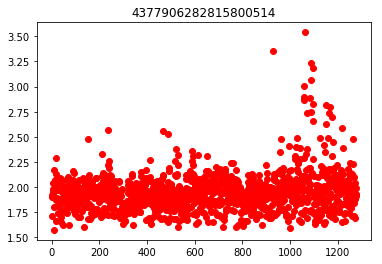

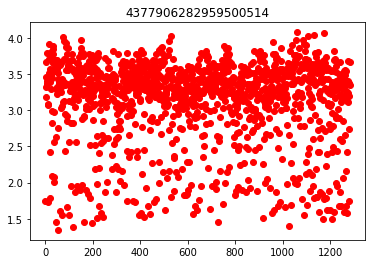

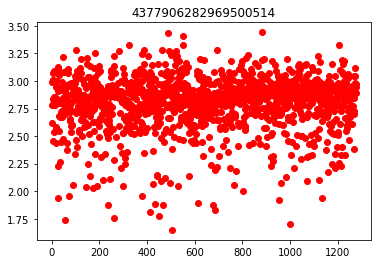

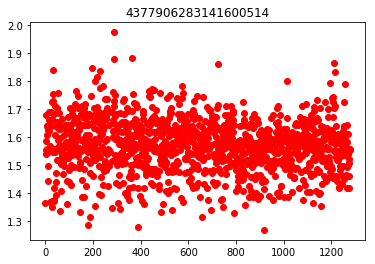

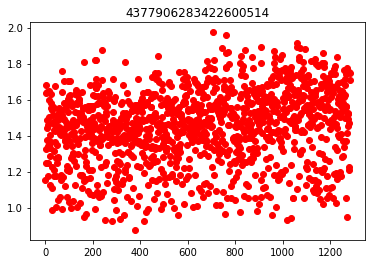

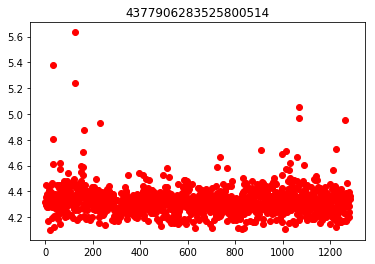

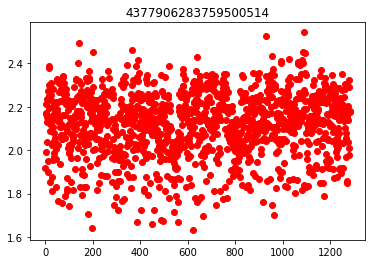

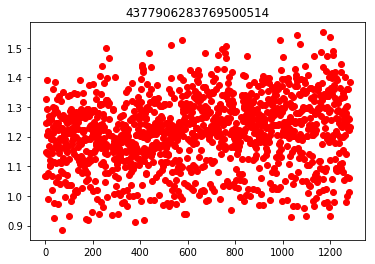

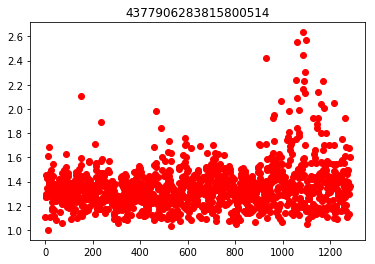

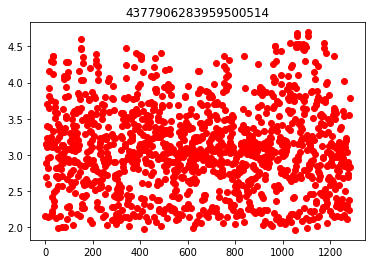

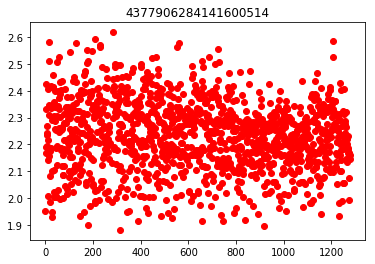

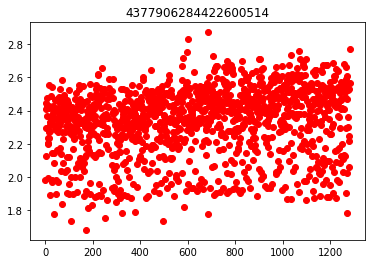

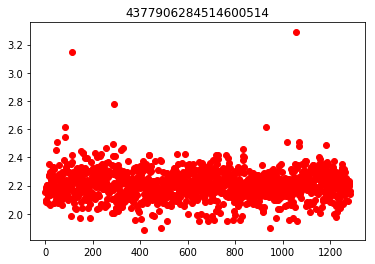

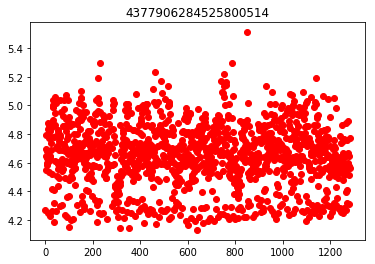

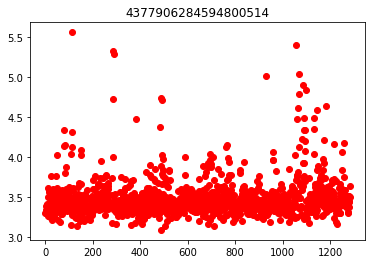

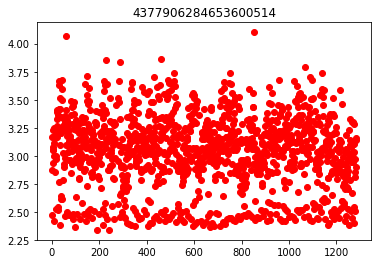

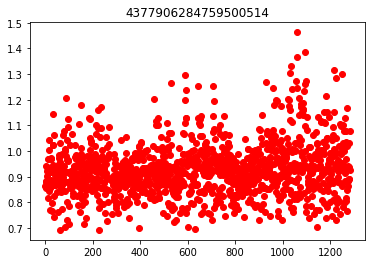

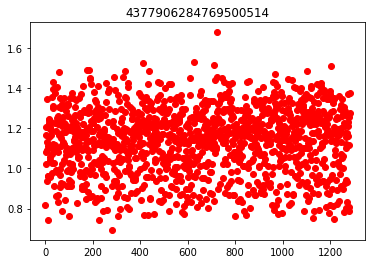

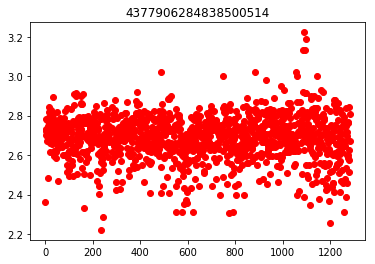

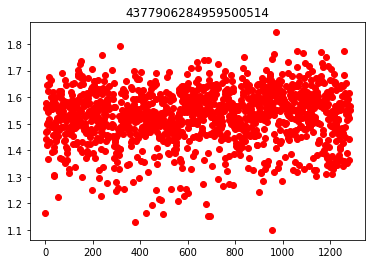

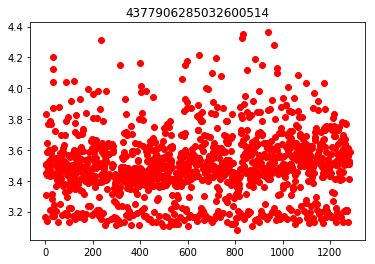

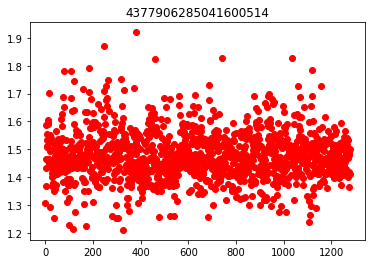

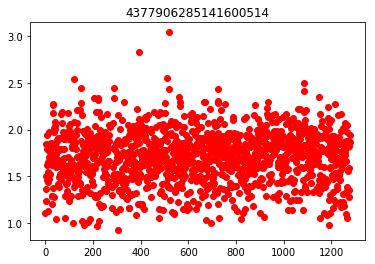

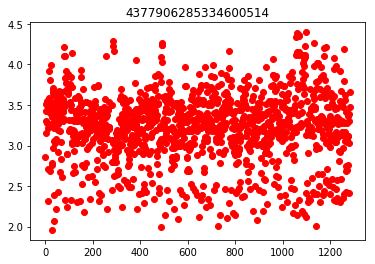

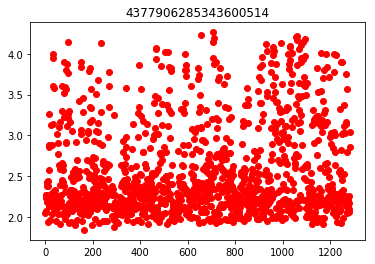

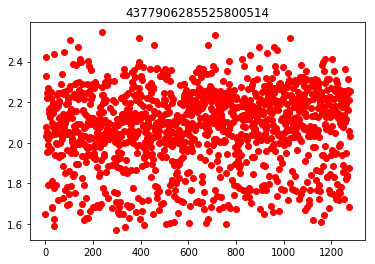

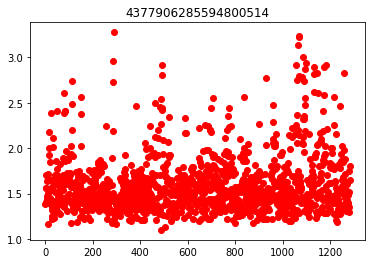

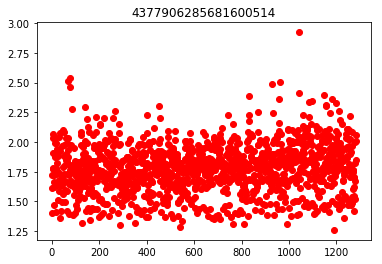

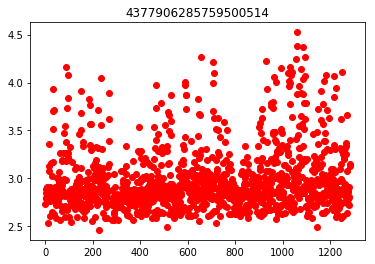

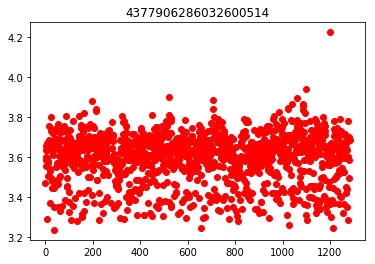

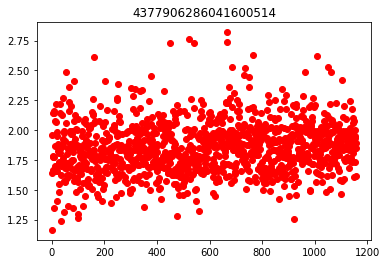

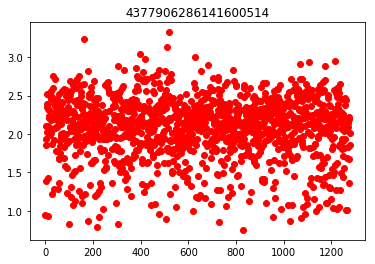

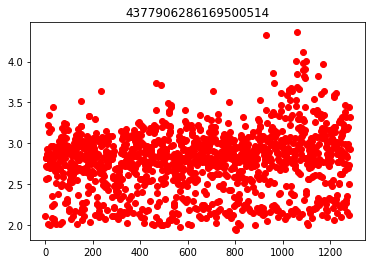

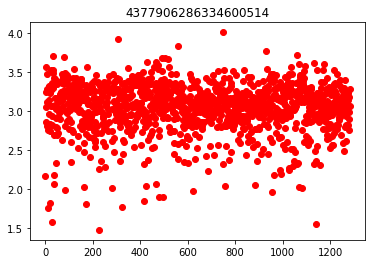

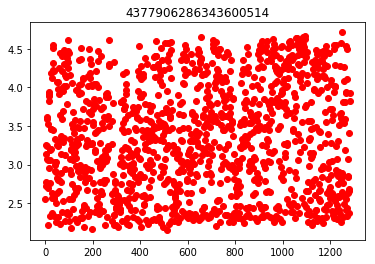

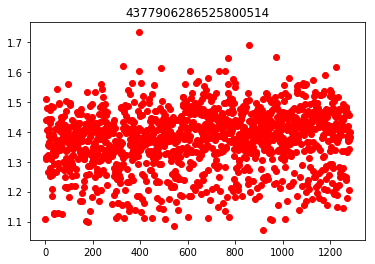

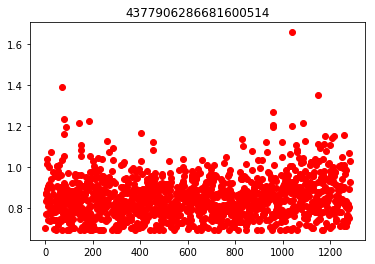

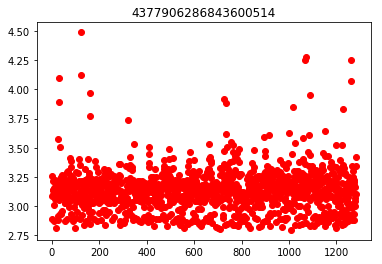

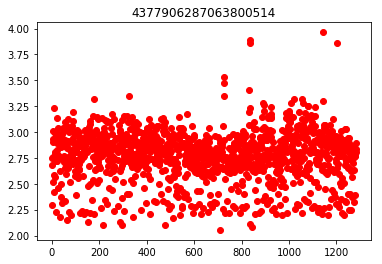

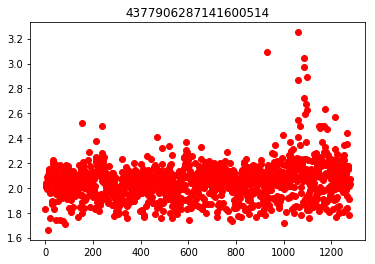

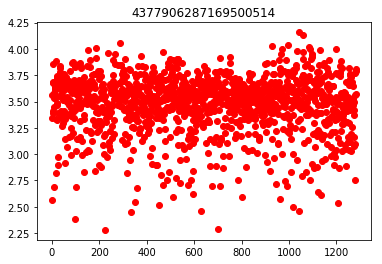

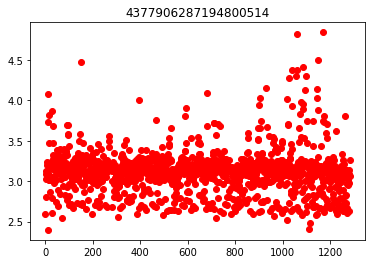

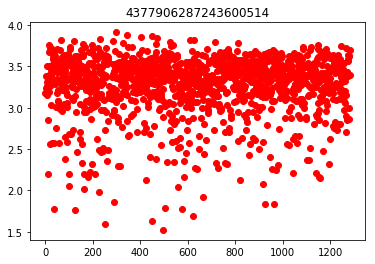

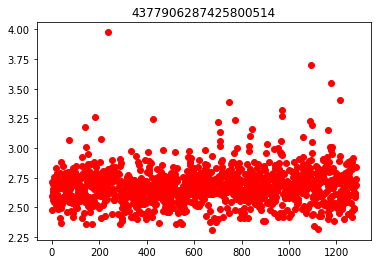

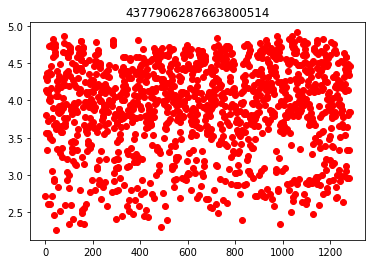

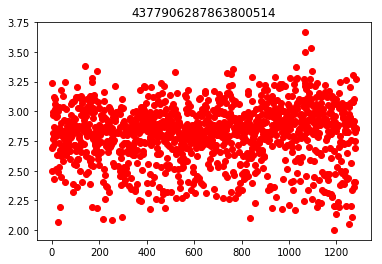

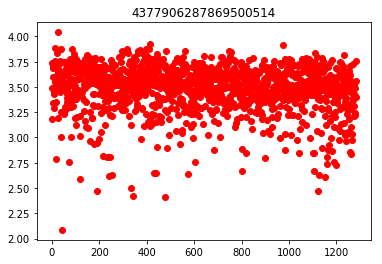

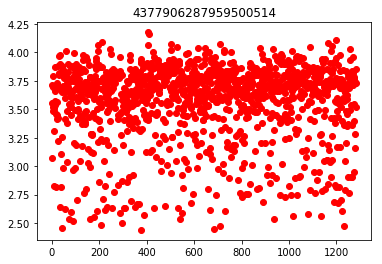

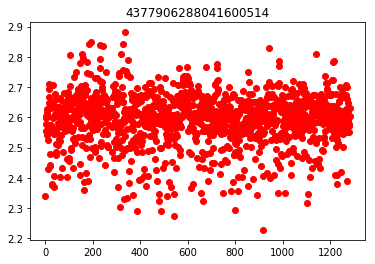

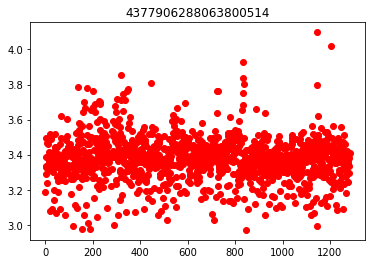

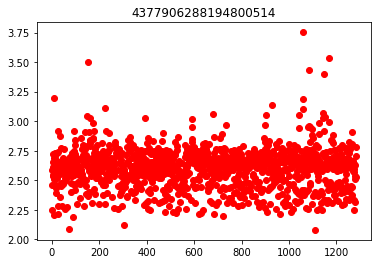

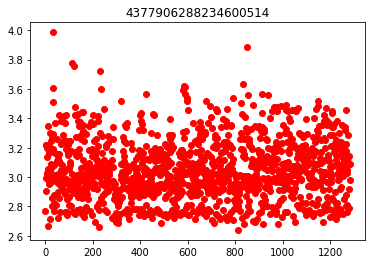

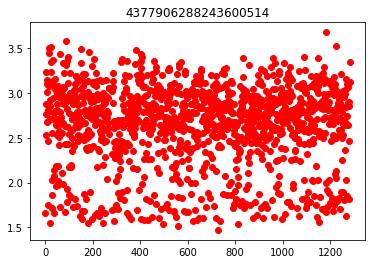

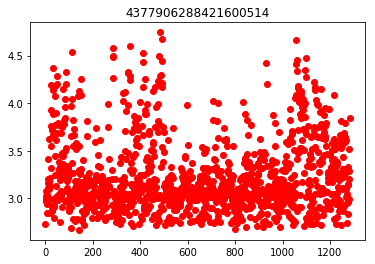

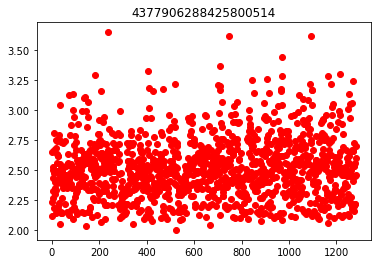

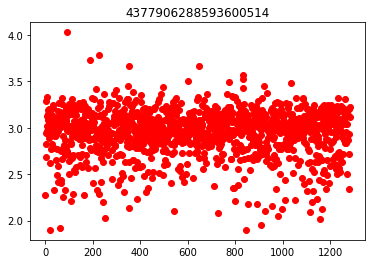

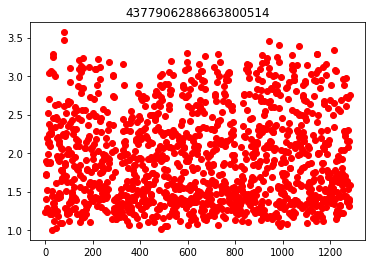

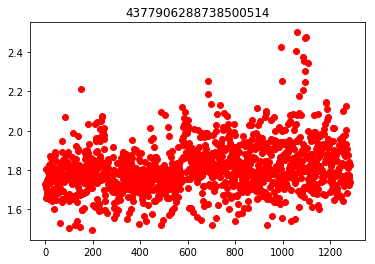

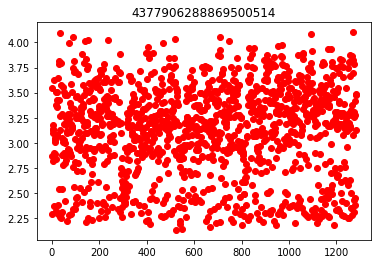

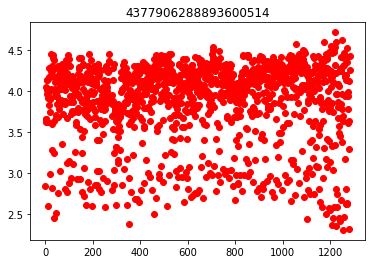

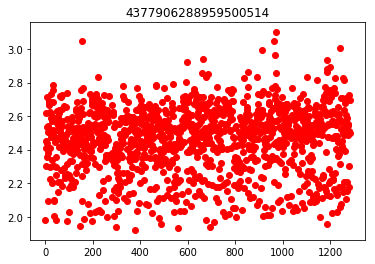

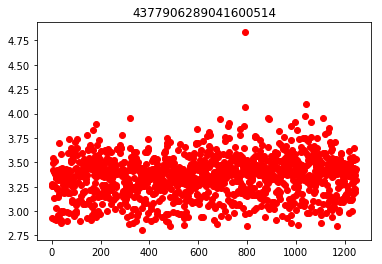

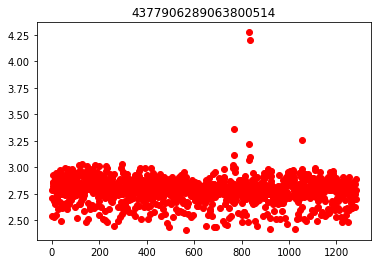

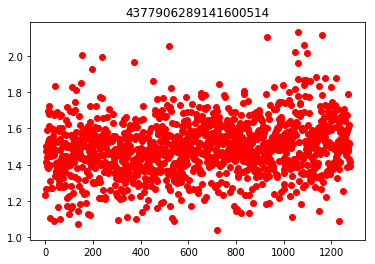

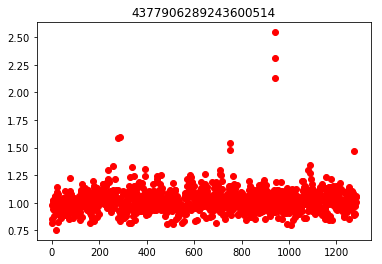

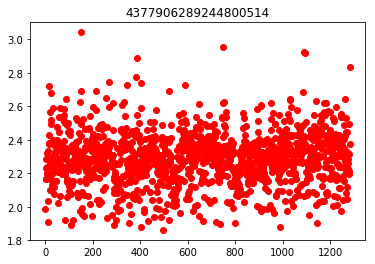

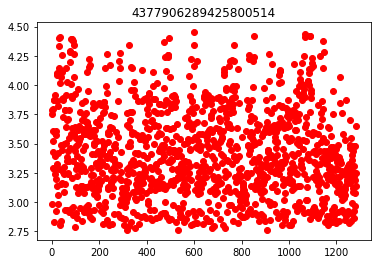

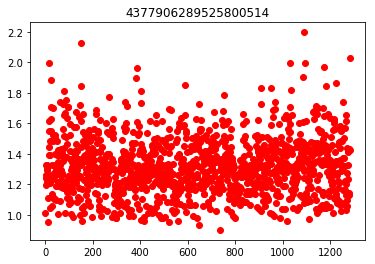

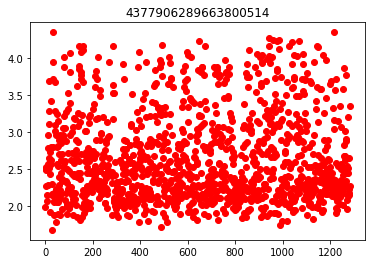

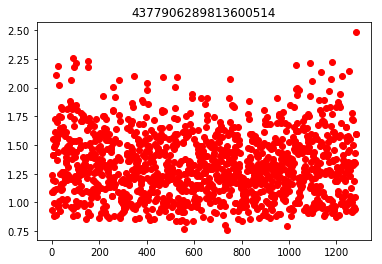

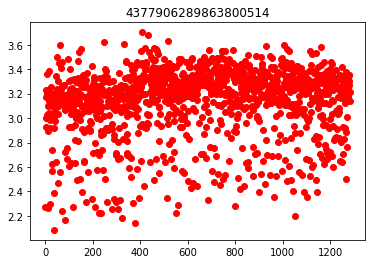

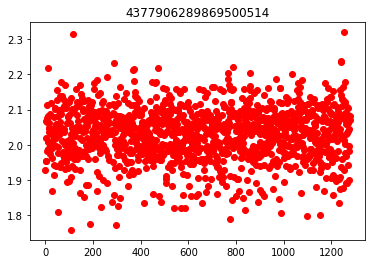

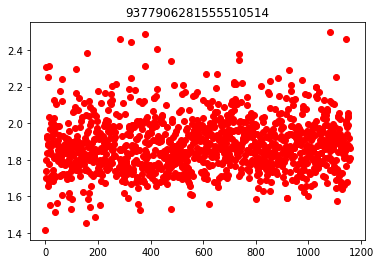

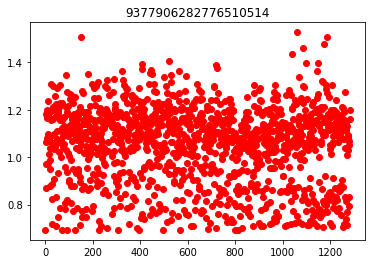

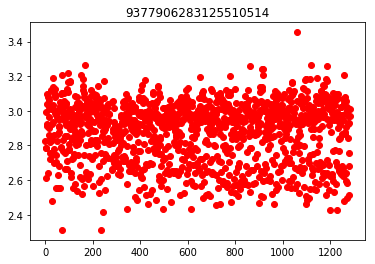

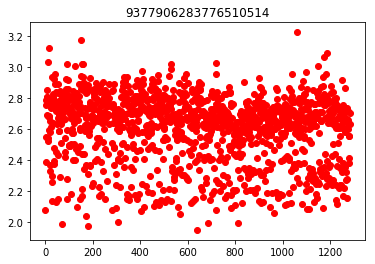

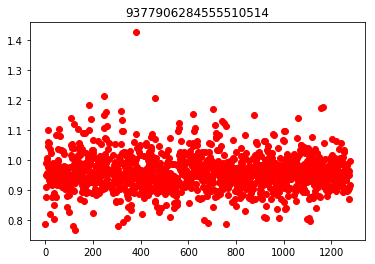

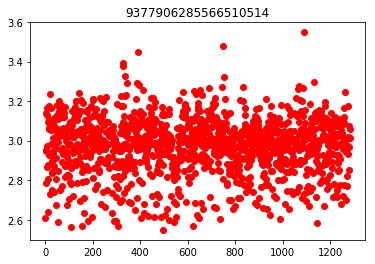

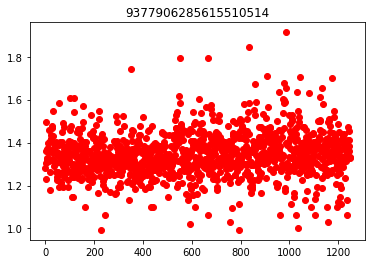

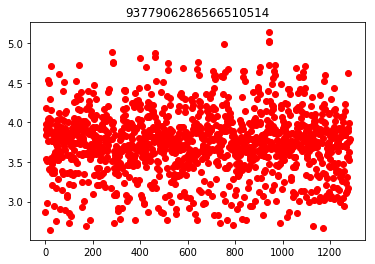

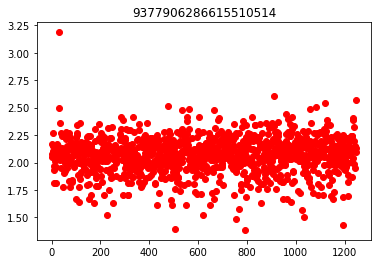

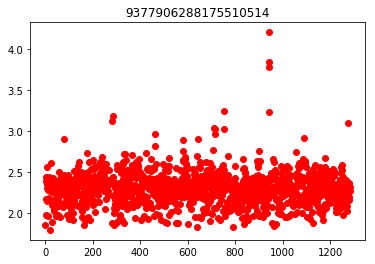

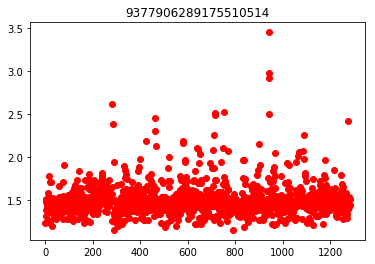

In [67]:
tmp = df.groupby('link_ID').apply(plot_date_trend)

In [68]:
# 看了一下所有的图片，发现并没有出现缺失特别严重的情况，因此季节趋势对所有的道路采用线性进行回归预测

### 2 day trend

In [69]:
# 查看day趋势
def minute_trend(group):
    tmp = group.groupby('hour_minute').mean().reset_index()
    return tmp

In [70]:
df['hour_minute'] = df.time_interval_begin.map(lambda x: x.strftime('%H-%M'))

In [71]:
tmp2 = df.groupby('link_ID').apply(minute_trend)

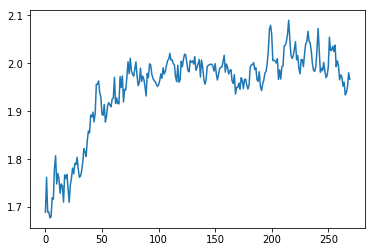

In [72]:
tmp2.loc['3377906280028510514']['travel_time2'].plot()
plt.show()

In [47]:
# 通过interpolate模块中UnivariateSpline()函数对含有噪声的数据进行插值运算

### 3 对缺失值进行预测，采用lightGBM

In [3]:
# 数据的基本走势已经被date_trend 和 hour_trend决定，剩下的就是研究travel_time如何围绕这两个trends上下变化
# 其实预测缺失值和之后的预测travel_time基本上是一致的
# 目前为止还有很多特征没有考虑，比如基本时间特征。lagging特征以及道路特征，接下来主要分析道路特征

### 4.分析提取特征

In [2]:
pre_train_path = '../data/pre_training.csv'
df = pd.read_csv(pre_train_path, delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})

link_info_path = '../data/gy_link_info.txt'
link_top_path = '../data/gy_link_top.txt'

# 道路的基本信息
link_infos = pd.read_csv(link_info_path,delimiter=';',dtype={'link_ID':object})

# 每条路的上下游关系
link_tops = pd.read_csv(link_top_path,delimiter=';',dtype={'link_ID':object})

### 4.1 与路相关的特征

In [6]:
# 基本特征（长度，宽度）
link_infos.head()

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


In [7]:
link_tops.head()

,link_ID,in_links,out_links
0,4377906289869500514,4377906285525800514,4377906281969500514
1,4377906284594800514,4377906284514600514,4377906285594800514
2,4377906289425800514,NaN,4377906284653600514
3,4377906284525800514,4377906281234600514,4377906280334600514
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514


In [8]:
df.head()

,link_ID,time_interval_begin,date,travel_time
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752


In [13]:
# 首先计算道路的基本信息
# 首先定义计算上下游数量的函数

def cal_link_nums(x):
    if pd.isnull(x):
        return 0
    else:
        return len(x.split('#'))    

In [14]:
link_tops['in_links_num'] = link_tops['in_links'].apply(cal_link_nums)
link_tops['out_links_num'] = link_tops['out_links'].apply(cal_link_nums)

In [15]:
link_tops.head()

,link_ID,in_links,out_links,in_links_num,out_links_num
0,4377906289869500514,4377906285525800514,4377906281969500514,1,1
1,4377906284594800514,4377906284514600514,4377906285594800514,1,1
2,4377906289425800514,NaN,4377906284653600514,0,1
3,4377906284525800514,4377906281234600514,4377906280334600514,1,1
4,4377906284422600514,3377906289434510514#4377906287959500514,4377906283422600514,2,1


In [16]:
link_infos = pd.merge(link_infos,link_tops,on=['link_ID'],how = 'left')

In [22]:
# 把上下游的数量组合作为一个特征
link_infos['links_in_out_num'] = link_infos["in_links_num"].astype('str') + "," + link_infos["out_links_num"].astype('str')

In [18]:
# 计算道路的面积
link_infos['area'] = link_infos['length'] * link_infos['width']

In [23]:
# 将link_infos和df结合
df2 = pd.merge(df, link_infos[['link_ID', 'length', 'width', 'links_in_out_num', 'area','in_links_num','out_links_num']], on=['link_ID'], how='left')

In [24]:
df2.head()

,link_ID,time_interval_begin,date,travel_time,length,width,links_in_out_num,area,in_links_num,out_links_num
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.174752,57,3,"1,1",171,1,1
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.174752,57,3,"1,1",171,1,1
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.174752,57,3,"1,1",171,1,1
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.174752,57,3,"1,1",171,1,1
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.174752,57,3,"1,1",171,1,1


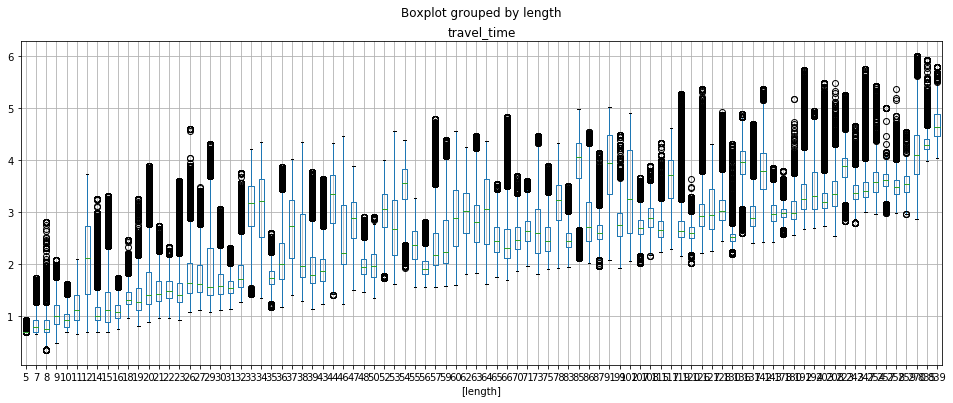

In [34]:

plt.rcParams['figure.figsize'] = (16.0, 6.0) 
# 接下来查看道路的长度特征与travel time的关系
df2.boxplot(by=['length'],column=['travel_time'])
plt.show()

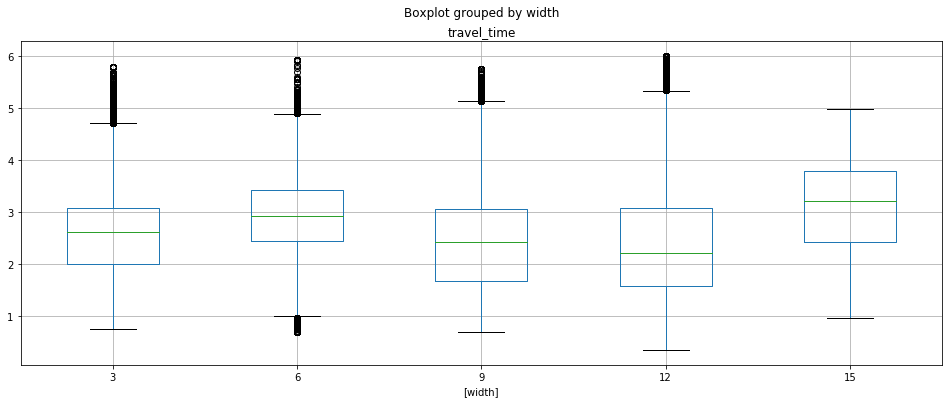

In [35]:
# 可以看出，路的长度与travel_time是成正比的。路越长，travel_time越大。路的长度特征比较重要
df2.boxplot(by=['width'],column=['travel_time'])
plt.show()

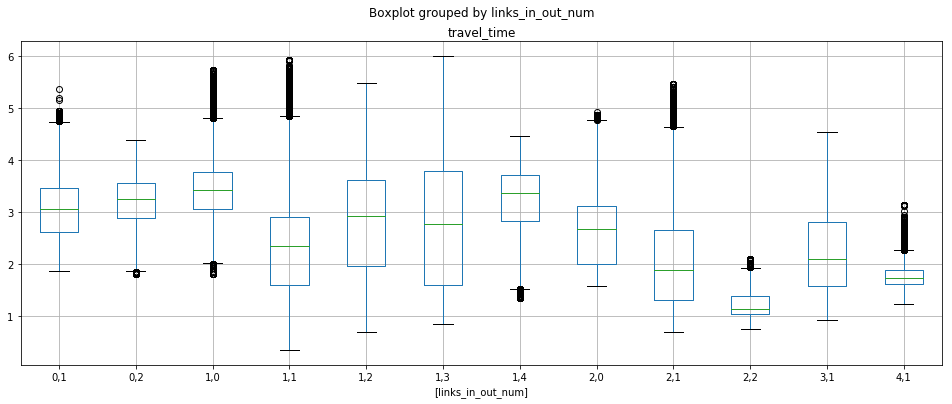

In [36]:
# 反观路的宽度，随着路的宽度的增大，车的通行时间并没有很明显的增大，反而在宽度为12米的时候有所下降，看来与常识有点出入，但是区分度还是有的，因此也可以作为特征之一

# 上下游特征
df2.boxplot(by=['links_in_out_num'],column=['travel_time'])
plt.show()

In [37]:
# 每个不同的组合，travel_time不同。可以作为特征

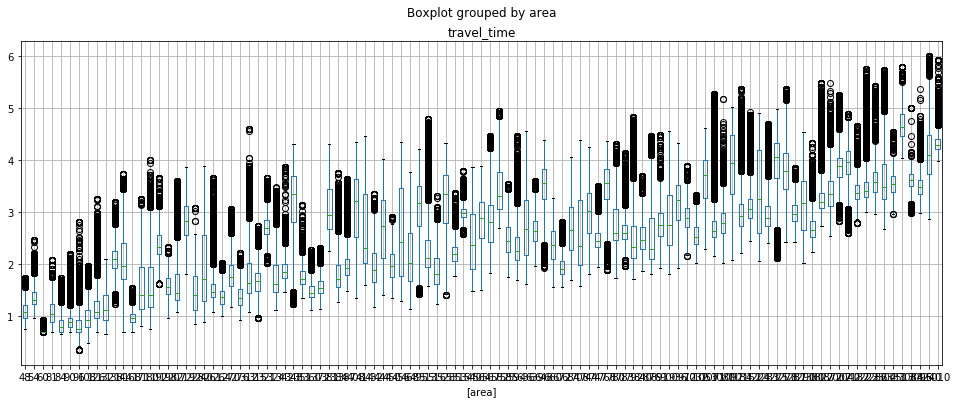

In [38]:
# 挺好奇路的面积有没有用
df2.boxplot(by=['area'],column=['travel_time'])
plt.show()

In [39]:
# 感觉和长度特征类似

# 接下来就是ID特征，对于决策树来说，onehot之后特征维度会增加为132维，可以采用label encode，因为树对连续值可以更好的分类处理
# 将ID特征重新分类，趋势是0最小，131最大
def mean_time(group):
    group['link_ID_en'] = group['travel_time'].mean()
    return group

df = df.groupby('link_ID').apply(mean_time)

In [40]:
df.head()

,link_ID,time_interval_begin,date,travel_time,link_ID_en
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.17,2.04
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.17,2.04
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.17,2.04
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.17,2.04
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.17,2.04


In [41]:
sorted_link = np.sort(df['link_ID_en'].unique())

In [42]:
sorted_link

array([0.71048615, 0.85018579, 0.8565517 , 0.8879349 , 0.93517925,
       0.95989007, 1.01257512, 1.02591401, 1.06605214, 1.09813522,
       1.1509949 , 1.21644049, 1.23334052, 1.32447517, 1.33942799,
       1.35425468, 1.36110882, 1.36771575, 1.37597347, 1.46284168,
       1.47901408, 1.49408044, 1.5008051 , 1.50975499, 1.53686692,
       1.57199175, 1.60196397, 1.60603473, 1.6623734 , 1.68266489,
       1.72304876, 1.72720786, 1.75135829, 1.75691075, 1.77306199,
       1.78934788, 1.79384097, 1.8161279 , 1.82155427, 1.85397642,
       1.8750432 , 1.88687944, 1.93984478, 1.94118788, 1.94197529,
       1.95707098, 1.97258421, 2.01966952, 2.03516733, 2.05726808,
       2.07734251, 2.08802892, 2.08902864, 2.12471762, 2.15560958,
       2.20908144, 2.23896044, 2.29376088, 2.30921426, 2.31429623,
       2.34887858, 2.37732964, 2.41437755, 2.44818861, 2.47515334,
       2.48319839, 2.49741545, 2.51595487, 2.52599688, 2.55328642,
       2.5655618 , 2.59607138, 2.61452804, 2.63016243, 2.64548

In [43]:
df['link_ID_en'] = df['link_ID_en'].map(lambda x: np.argmin(x >= sorted_link))

In [44]:
 df.head()

,link_ID,time_interval_begin,date,travel_time,link_ID_en
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.17,49
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.17,49
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.17,49
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.17,49
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.17,49


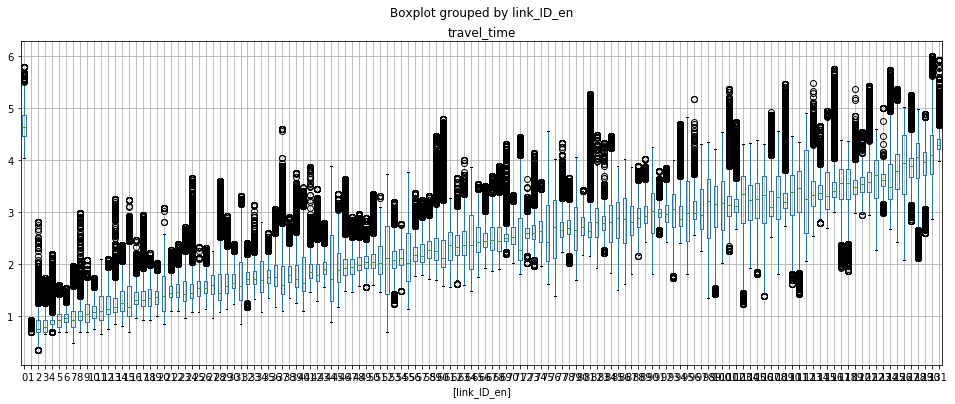

In [45]:
df.boxplot(by=['link_ID_en'],column=['travel_time'])
plt.show()

## 4.2 与时间相关的特征

In [46]:
# lagging 特征，这个travel_time的时间感觉和当天前10分钟的关系较大，个人认为和前几天的数据不相关
# 这个就是将前几分钟的travel_time当作一个lagging特征
# 思路就是将最初的数据进行复制，然后将时间往前移动，对travel_time进行重命名，然后对数据进行合并
# 但是有一个问题，最初的数据是没有lagging特征的，这部分数据要么不作为训练数据，要么把自己的数据复制作为特征
def create_lagging_minute(df,df_origin,i):
    df1 = df_origin.copy()
    df1['time_interval_begin'] = df1['time_interval_begin'] + pd.DateOffset(minutes = i * 2)
    df1 = df1.rename(columns = {'travel_time':'lagging' + str(i)})
    df2 = pd.merge(df,df1[['link_ID','time_interval_begin','lagging' + str(i)]],on = ['link_ID','time_interval_begin'],how='left')
    return df2

In [50]:
df1 = create_lagging_minute(df, df, 1)
for i in range(2, 3):
    df1 = create_lagging_minute(df1, df, i)

In [51]:
df1.head()

,link_ID,time_interval_begin,date,travel_time,link_ID_en,lagging1,lagging2
0,4377906289869500514,2017-03-01 06:00:00,2017-03-01,2.17,49,nan,nan
1,4377906289869500514,2017-03-01 06:02:00,2017-03-01,2.17,49,2.17,nan
2,4377906289869500514,2017-03-01 06:04:00,2017-03-01,2.17,49,2.17,2.17
3,4377906289869500514,2017-03-01 06:06:00,2017-03-01,2.17,49,2.17,2.17
4,4377906289869500514,2017-03-01 06:08:00,2017-03-01,2.17,49,2.17,2.17


In [52]:
# 基本的时间特征
df1['hour'] = df1['time_interval_begin'].dt.hour
df1['week_day'] = df1['time_interval_begin'].map(lambda x: x.weekday() + 1)
df1['month'] = df1['time_interval_begin'].dt.month

### 测试groupby函数

In [5]:
file = '../data/pre_training.csv'
df = pd.read_csv(file, delimiter=';', parse_dates=['time_interval_begin'], dtype={'link_ID': object})
# 将travel_time存储起来
df['travel_time2'] = df['travel_time']

# 这个函数应用到groupby，可以对分组后的函数进行计算
def date_trend(group):
    # 一个新的对象
    # key是两个，link_ID和date，重新设置索引
    tmp = group.groupby('date_hour').mean().reset_index()

    # 其中z是一个函数
    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]


    y = tmp['travel_time'].values
    nans, x = nan_helper(y)
    # nans是一个true/false的矩阵

    regr = linear_model.LinearRegression()
    regr.fit(x(~nans).reshape(-1, 1), y[~nans].reshape(-1, 1))
    tmp['date_trend'] = regr.predict(tmp.index.values.reshape(-1, 1)).ravel()

    group = pd.merge(group, tmp[['date_trend', 'date_hour']], on='date_hour', how='left')

    return group

# 季节性趋势，以每小时进行度量
df['date_hour'] = df.time_interval_begin.map(lambda x: x.strftime('%Y-%m-%d-%H'))
df = df.groupby('link_ID').apply(date_trend)

In [10]:
df.head()

link_ID time_interval_begin        date  \
link_ID                                                                      
3377906280028510514 0  3377906280028510514 2017-03-01 06:00:00  2017-03-01   
                    1  3377906280028510514 2017-03-01 06:02:00  2017-03-01   
                    2  3377906280028510514 2017-03-01 06:04:00  2017-03-01   
                    3  3377906280028510514 2017-03-01 06:06:00  2017-03-01   
                    4  3377906280028510514 2017-03-01 06:08:00  2017-03-01   

                       travel_time  travel_time2      date_hour  date_trend  
link_ID                                                                      
3377906280028510514 0          NaN           NaN  2017-03-01-06    1.937947  
                    1          NaN           NaN  2017-03-01-06    1.937947  
                    2          NaN           NaN  2017-03-01-06    1.937947  
                    3          NaN           NaN  2017-03-01-06    1.937947  
                    4          NaN           NaN  2017-03-01-06    1.937947

In [ ]:
# 说一下我的理解把
# 首先df.groupby('link_ID'),已经根据link_ID进行拆分数据，每个单独的对象key已经是link_ID
# 接下来对单独的对象继续聚合，其中groupby('date_hour').mean()，即对每个单独的link_ID

In [ ]:
def minute_trend(group):
    tmp = group.groupby('hour_minute').mean().reset_index
    spl = UnivariateSpline(tmp.index, tmp['travel_time'].values, s=0.5, k=3)
    tmp['minute_trend'] = spl(tmp.index)
    group = pd.merge(group, tmp[['minute_trend', 'hour_minute']], on='hour_minute', how='left')
    return group